In [9]:
import pandas as pd
import numpy as np
import os

# --- CRITICAL: Load the new Global Macro dataset ---
data_path = '../../data/eurusd_h1_features.csv'
df = pd.read_csv(data_path, index_col='time', parse_dates=True)

print("EURUSD H1 feature data loaded successfully.")
display(df.head())

EURUSD H1 feature data loaded successfully.


,open,high,low,close,volume,ichimoku_senkou_span_a,ichimoku_senkou_span_b,ichimoku_tenkan_sen,ichimoku_kijun_sen,ichimoku_chikou_span,...,BBB_20_2.0,BBP_20_2.0,ATRr_14,ADX_14,DMP_14,DMN_14,SQZ_20_2.0_20_1.5,SQZ_ON,SQZ_OFF,SQZ_NO
time,,,,,,,,,,,,,,,,,,,,,
2020-01-14 10:00:00+00:00,1.11338,1.11345,1.11262,1.11303,1847,1.111788,1.111045,1.11353,1.112980,1.11489,...,0.116049,0.004413,0.000695,35.164893,18.919802,16.165903,-0.000030,1,0,0
2020-01-14 11:00:00+00:00,1.11303,1.11303,1.11194,1.11206,1732,1.111738,1.111045,1.11319,1.113165,1.11522,...,0.171165,-0.301387,0.000723,33.453425,16.882456,21.142960,-0.000405,0,1,0
2020-01-14 12:00:00+00:00,1.11206,1.11207,1.11050,1.11102,3061,1.111738,1.111045,1.11247,1.112595,1.11521,...,0.260943,-0.332919,0.000784,33.685720,14.466117,31.244421,-0.000918,0,1,0
2020-01-14 13:00:00+00:00,1.11102,1.11233,1.11042,1.11217,3034,1.111738,1.111045,1.11243,1.112555,1.11595,...,0.275196,0.114706,0.000864,33.384978,14.331335,26.310714,-0.001137,0,1,0
2020-01-14 14:00:00+00:00,1.11217,1.11232,1.11136,1.11220,2609,1.111765,1.111045,1.11243,1.112555,1.11575,...,0.286510,0.164538,0.000871,33.105717,13.202861,24.238963,-0.001320,0,1,0


In [10]:
def define_target(df, atr_multiplier_tp=3.0, atr_multiplier_sl=1.5, lookahead_candles=30):
    """
    Creates the target variable based on dynamic, volatility-based (ATR) targets.
    """
    df['target'] = 0
    
    atr_column_name = next((col for col in df.columns if 'ATRr_' in col), None)
    if not atr_column_name:
        raise ValueError("ATR column not found in DataFrame. Please ensure it's calculated in Notebook 1.")
        
    for i in range(len(df) - lookahead_candles):
        entry_price = df['close'].iloc[i]
        atr_value = df[atr_column_name].iloc[i]
        
        future_window_high = df['high'].iloc[i+1 : i+1+lookahead_candles]
        future_window_low = df['low'].iloc[i+1 : i+1+lookahead_candles]
        
        take_profit_buy = entry_price + (atr_value * atr_multiplier_tp)
        stop_loss_buy = entry_price - (atr_value * atr_multiplier_sl)
        
        take_profit_sell = entry_price - (atr_value * atr_multiplier_tp)
        stop_loss_sell = entry_price + (atr_value * atr_multiplier_sl)
        
        buy_profit_hit_time = future_window_high[future_window_high >= take_profit_buy].first_valid_index()
        buy_loss_hit_time = future_window_low[future_window_low <= stop_loss_buy].first_valid_index()
        
        if buy_profit_hit_time is not None and (buy_loss_hit_time is None or buy_profit_hit_time < buy_loss_hit_time):
            df.loc[df.index[i], 'target'] = 1
            continue

        sell_profit_hit_time = future_window_low[future_window_low <= take_profit_sell].first_valid_index()
        sell_loss_hit_time = future_window_high[future_window_high >= stop_loss_sell].first_valid_index()
            
        if sell_profit_hit_time is not None and (sell_loss_hit_time is None or sell_profit_hit_time < sell_loss_hit_time):
            df.loc[df.index[i], 'target'] = -1
            continue
            
    return df

print("New dynamic define_target function created and ready.")

New dynamic define_target function created and ready.


Dynamic target labeling complete.

Target Distribution:
target
 1    13747
-1    13578
 0     7872
Name: count, dtype: int64


<Axes: title={'center': 'Distribution of EURUSD Target Labels'}, xlabel='target'>

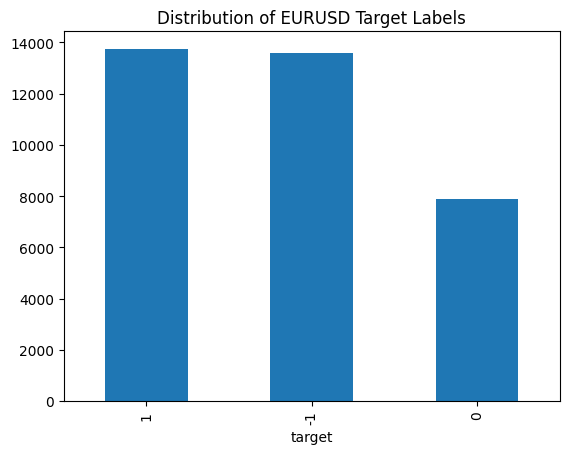

In [11]:
# --- CRITICAL: Adjust parameters for Forex ---
# Forex is generally less volatile than crypto. A 2:1 R/R might be too wide.
# Let's start with a 1.5:1 Reward-to-Risk ratio to ensure we get enough labeled trades.
# We will also increase the lookahead period slightly to give these trades more time to play out.
labeled_df = define_target(
    df, 
    atr_multiplier_tp=2.25, 
    atr_multiplier_sl=1.5, 
    lookahead_candles=40
)

print("Dynamic target labeling complete.")

# Analyze the distribution of our new targets
target_distribution = labeled_df['target'].value_counts()
print("\nTarget Distribution:")
print(target_distribution)

# Plot the new distribution
target_distribution.plot(kind='bar', title='Distribution of EURUSD Target Labels')

In [12]:
# --- CRITICAL: Save to a new, descriptive filename ---
output_path = '../../data/eurusd_h1_labeled.csv'
labeled_df.to_csv(output_path)

print(f"\nLabeled data for EURUSD H1 saved successfully to: {output_path}")


Labeled data for EURUSD H1 saved successfully to: ../../data/eurusd_h1_labeled.csv
